In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
import numpy as np
import glob
import pandas as pd
import shutil

from torchvision import datasets, models, transforms
import torchvision
import torch
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import copy
plt.ion()

In [3]:
def get_average_image_size(category_name):
    dir_img = f'./data/{category_name}/*'
    image_sizes = list(map(lambda x: Image.open(x).size, glob.iglob(dir_img)))

    total_x = 0
    total_y = 0

    for x,y in image_sizes:
        total_x += x
        total_y += y

    return (round(total_x/len(image_sizes)), round(total_y/len(image_sizes))), len(image_sizes)


In [4]:
list_of_labels = os.listdir('./data/')
list_of_labels.remove('train')
list_of_labels.remove('test')
list_of_labels.remove('val')
# list_of_labels.remove('.ipynb_checkpoints')

num_all_imgs = 0
for category in list_of_labels:
    average_img_size, category_images = get_average_image_size(category)
    num_all_imgs += category_images
#     print(category)
#     print(f"Average size in pixel: {average_img_size}")
#     print(f"Total number of imags: {category_images}")
#     print("========================")
    

lables_index_number = {index : value for index, value in enumerate(list_of_labels)}
print(lables_index_number)
print(num_all_imgs)


{0: 'paper', 1: 'food wrapper', 2: 'tissue', 3: 'cardboard', 4: 'plastic bags', 5: 'glass', 6: 'pizza box', 7: 'plastic bottle'}
962


In [5]:
def split_data_into_train_test_val(data_dir, test_percent, val_percent):

    list_of_labels = os.listdir(data_dir)
    list_of_labels.remove('train')
    list_of_labels.remove('test')
    list_of_labels.remove('val')
#     list_of_labels.remove('.ipynb_checkpoints')
    image_file_paths_test = []
    image_file_paths_val = []
    image_file_paths_train = []

    for index, category in enumerate(list_of_labels):
        file_path = glob.glob(f'{data_dir}{category}/*.jpg')
        file_label = [index]*len(file_path)

        category_tuples = [(file_path[i], file_label[i]) for i in range(0, len(file_path))]

        test_size = round(len(file_path) * test_percent)
        val_size = round((len(file_path) - test_size) * val_percent)
        train_size = len(file_path) - test_size - val_size

        image_file_paths_test += category_tuples[0:test_size]
        image_file_paths_val += category_tuples[test_size:][0:val_size]
        image_file_paths_train += category_tuples[test_size:][val_size:]
    
    return image_file_paths_test, image_file_paths_val, image_file_paths_train

image_file_paths_test, image_file_paths_val, image_file_paths_train = split_data_into_train_test_val(
    data_dir='./data/', 
    test_percent=0.2, 
    val_percent=0.2
)

print(len(image_file_paths_test))
print(len(image_file_paths_train))
print(len(image_file_paths_val))
print(len(image_file_paths_test)/(len(image_file_paths_test) + len(image_file_paths_train) + len(image_file_paths_val)))

191
617
154
0.19854469854469856


In [6]:
data_ordered_train = pd.DataFrame(image_file_paths_train, columns=['ImagePath', 'ImageLabel'])
data_ordered_val = pd.DataFrame(image_file_paths_val, columns=['ImagePath', 'ImageLabel'])
data_ordered_test = pd.DataFrame(image_file_paths_test, columns=['ImagePath', 'ImageLabel'])


data_shuffled_train = data_ordered_train.sample(frac=1, axis=0).reset_index(drop=True)
data_shuffled_val = data_ordered_val.sample(frac=1, axis=0).reset_index(drop=True)
data_shuffled_test = data_ordered_test.sample(frac=1, axis=0).reset_index(drop=True)
print(data_shuffled_train.shape)
print(data_shuffled_test.shape)
print(data_shuffled_val.shape)


(617, 2)
(191, 2)
(154, 2)


In [7]:
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/val

mkdir: ./data/train: File exists
mkdir: ./data/test: File exists
mkdir: ./data/val: File exists


In [8]:
print(len(data_shuffled_val.ImagePath))

154


In [9]:
data_name_map = {'train': data_shuffled_train, 'test': data_shuffled_test, 'val': data_shuffled_val}

def copy_and_move_files(folder_name, data_name_map):
    
    if not os.path.exists(f'./data/{folder_name}'):
            os.mkdir(f'./data/{folder_name}')
            
    for index, file in  enumerate(data_name_map[folder_name].ImagePath):
        class_name = lables_index_number[data_name_map[folder_name].ImageLabel.iloc[index]]

        if not os.path.exists(f'./data/{folder_name}/{class_name}'):
            os.mkdir(f'./data/{folder_name}/{class_name}')
        shutil.copyfile(file, f'./data/{folder_name}/{class_name}/{file.split("/")[-1]}')
    
copy_and_move_files('train', data_name_map)
copy_and_move_files('val', data_name_map)
copy_and_move_files('test', data_name_map)


In [10]:

# img = np.array(Image.open(data_shuffled_train.iloc[0][0]))

# print(img.shape)
# # print(np.array(img))

# print(data_shuffled_train.iloc[0][0])

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

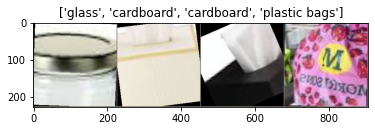

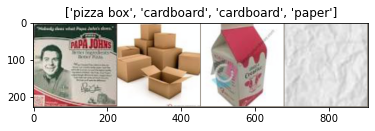

In [12]:
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

dataset = {x: datasets.ImageFolder(f'./data/{x}', data_transform[x]) for x in ['train', 'val']}

data_loader = {x: torch.utils.data.DataLoader(
    dataset[x], batch_size = 4, shuffle=True, num_workers=4) for x in ['train', 'val']}
class_names = {x: dataset[x].classes for x in ['train', 'val'] }

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs_train, classes_train = next(iter(data_loader['train']))
out_train = torchvision.utils.make_grid(inputs_train)
imshow(out_train, title=[class_names['train'][x] for x in classes_train])

inputs_val, classes_val = next(iter(data_loader['val']))
out_val = torchvision.utils.make_grid(inputs_val)
imshow(out_val, title=[class_names['val'][x] for x in classes_val])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch : {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase =='train'):
                    outputs = model(inputs)
                    print(outputs)
                    print(labels)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase =='train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss.__round__(4)} Acc: {epoch_acc.__round__(4)}")
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')
    
    model.load_state_dict(best_model_wts)
    return model
    
    

In [14]:
def visualise_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data([j]))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

print(num_ftrs)
print(class_names)
print(len(class_names['train']))
model_ft.fc = nn.Linear(num_ftrs, len(class_names['train']))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimiser_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft, step_size=7, gamma=0.1)

512
{'train': ['cardboard', 'food wrapper', 'glass', 'paper', 'pizza box', 'plastic bags', 'plastic bottle', 'tissue'], 'val': ['cardboard', 'food wrapper', 'glass', 'paper', 'pizza box', 'plastic bags', 'plastic bottle', 'tissue']}
8


In [ ]:
model_ft = train_model(model_ft, criterion, optimiser_ft, exp_lr_scheduler, num_epochs=25)

Epoch : 1/25
----------
